In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from collections import Counter
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import gensim

In [2]:
# Load the data
data = pd.read_csv('updated_processed_data.csv')

In [3]:
data.head()

PMID                                              TITLE  \
0  29982332  Trends in the development of miRNA bioinformat...   
1  30222249            RNA-seq: Basic Bioinformatics Analysis.   
2  31363220  scGen predicts single-cell perturbation respon...   
3  24272431                    Introduction to bioinformatics.   
4  31699960  Identification of Hub Genes and Pathways in a ...   

                                            ABSTRACT  DATE OF PUBLICATION  \
0  MicroRNAs (miRNAs) are small noncoding RNAs th...                 2019   
1  Quantitative analysis of gene expression is cr...                 2018   
2  Accurately modeling cellular response to pertu...                 2019   
3  Bioinformatics is an interdisciplinary field m...                 2014   
4  BACKGROUND This study aimed to identify hub ge...                 2019   

  PUBLICATION TYPE PLACE OF PUBLICATION  \
0  Journal Article              England   
1  Journal Article        United States   
2  Journal Article        United States   
3  Journal Article        United States   
4  Journal Article        United States   

                                       JOURNAL TITLE  \
0                        Briefings in bioinformatics   
1             Current protocols in molecular biology   
2                                     Nature methods   
3       Methods in molecular biology (Clifton, N.J.)   
4  Medical science monitor : international medica...   

                                            KEYWORDS  
0  bibliometric; bioinformatics tools; miRNA; ran...  
1  RNA-seq; bioinformatics; differentially expres...  
2                                                NaN  
3                                                NaN  
4                                                NaN

In [4]:
# Check for duplicates
print(f'Duplicates: {data.duplicated().sum()}')

# Remove duplicates
data = data.drop_duplicates()

# Check for null values
print(f'Null values:\n{data.isnull().sum()}')

# Drop rows with null values
data = data.dropna()

Duplicates: 0
Null values:
PMID                        0
TITLE                       0
ABSTRACT                    0
DATE OF PUBLICATION         0
PUBLICATION TYPE            0
PLACE OF PUBLICATION        0
JOURNAL TITLE               0
KEYWORDS                31393
dtype: int64


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77785 entries, 0 to 109177
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PMID                  77785 non-null  int64 
 1   TITLE                 77785 non-null  object
 2   ABSTRACT              77785 non-null  object
 3   DATE OF PUBLICATION   77785 non-null  int64 
 4   PUBLICATION TYPE      77785 non-null  object
 5   PLACE OF PUBLICATION  77785 non-null  object
 6   JOURNAL TITLE         77785 non-null  object
 7   KEYWORDS              77785 non-null  object
dtypes: int64(2), object(6)
memory usage: 5.3+ MB


In [6]:
# Combine title and abstract for topic modeling
data['text'] = data['TITLE'] + ' ' + data['ABSTRACT'] + ' ' + data['KEYWORDS']

# Remove punctuation and lower the text
data['text'] = data['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)).lower())

In [7]:
# Define custom phrases
custom_phrases = ['gene expression', 'molecular docking',
                'next generation sequence analysis', 'ngs analysis',
                'virtual screening',
                'in- silico bioinformatics analysis',
                'computational analysis',
                'in-silico drug discovery',
                'drug discovery',
                'in-silico structural analysis',
                'structural anaysis',
                'in-silico functional analysis',
                'functional analysis',
                'mutational analysis',
                'sequence annotation',
                'genome sequence analysis',
                'proteome sequence analysis',
                'exome sequence analysis']

In [8]:
# Ensure custom phrases are not split
for phrase in custom_phrases:
    data['text'] = data['text'].apply(lambda x: x.replace(phrase, phrase.replace(' ', '_')))

In [9]:
# Remove stopwords
custom_stopwords = ['background', 'material and methods','results', 'conclusion', 'motivation', 'implementation', 'participants', 'revealed', 'diversity',
                    'supplementary information', 'objectives', ',', ':', ';', 'identified', 'cell', 'cells', 'protein', 'compared', 'health', 'patient', 'use', 
                    'proteins', 'network', 'study', 'virus', 'degs','pathways', 'differentially', 'human', 'methods', 'associated', 'diagnosis', 'group', 
                    'available', 'model', 'new', 'models', 'method', 'using', 'information', 'results', 'data', 'samples', 'immune', 'breast', 'prognostics',
                    'species', 'stress', 'development', 'survival', 'variants', 'compounds', 'binding', 'acid', 'enzyme', 'esidues','patients', 'tumor',
                    'inhibitors', 'potential', 'activity', 'clinical', 'treatment', 'care', 'images', 'hub', 'pathway', 'regulation', 'structure', 'vaccine',
                    'supplementry', 'information', 'tools', 'reads', 'crc', 'prognosis', 'lung', 'variant', 'genetic', 'levels', 'transcription', 'bacteria',
                    'pathogenic', '3d', 'imaging', 'reality','vr', 'ct', 'singlecell', 'proliferation', 'signaling', 'role', 'effects', 'host', 'baterial',
                    'spike', 'protease', 'mpro', 'viral', 'sarscov2', 'strain', 'strains', 'noncoding', 'target', 'targets', 'mice', 'infection', 'prediction',
                    'design', 'used', 'based', 'datasets', 'approach', 'prostate', 'colorectal', 'novel', 'studies', 'dynamics', 'inhibitor', 'learning', 'disease',
                    'gastric', 'cancers', 'ovarian', 'compound', 'showed', 'vitro', 'peptides', 'computational', 'approaches', 'research', 'bioinformatics', 
                    'genomic', 'dna', 'mutations', 'mutation', 'associated', 'related', 'involved', 'enrichment', 'ppi', 'database', 'supplementary', 'machine', 
                    'implementaion', 'availability', 'online', 'performance', 'molecules', 'dynamics', 'active', 'dignostic', 'ci', '95', 'cohort', 'risk', 'tnbc',
                    'tumors', 'lines', 'pancreatic', 'metastasis' 'bc', 'planning', 'surgery', 'review', 'covid19', 'small', 'syndrme', 'fmilies', 'heterozygous', 
                    'missense', 'family', 'hcc', 'carcinoma', 'heptatocellutar', 'signature', 'infiltration', 'bacterial', 'diagnostic', 'surgical', 'included', 
                    'assessment', 'image', 'medical', 'performed', 'conclusions', 'time', 'significantly', 'prognostic', 'cancer', 'phylogebetic', 'different', 
                    'vs', 'higher', 'cases', 'predicted', 'funstion', 'regions', 'peptide', 'antimicrobial', 'coli', 'amino', 'resistance', 'biological', 'developed', 
                    'tool', 'accuracy', 'algorithm', 'set', 'implementation', 'proposed', 'interactions', 'inhibition', 'response', 'growth', 'algorithms', 
                    'clustering', 'upregulated', 'kegg', 'enriched', 'key', 'derivatives', 'potent', 'energy', 'ligands', 'therapy', 'colon', 'nsclc', 'atlas', 
                    'metastasis', 'progression', 'tcga', 'regulatory', 'predicted', 'outcomes', 'mean', 'medical', 'training', 'surgical', 'transcriptome', 
                    'technologies', 'testing', 'tergeted', 'detection', 'isolates', 'assembly', 'resistance', 'repurposing', 'candidates', 'therapeutic', 'simulation',
                    'tuberculosis', 'approved', 'antiviral','quality','cognitive','significant','tomography','technology','computed','years','identification', 'bone',
                    'ad', 'aortic', 'artery','ic50','assay', 'synthesized', 'synthesis', 'inhibitory','isolated', 'fetal', 'pathogen', 'respiratory','targeted','rare',
                    'biomarkers','identify','expressed', 'plants','plant','expressed', 'methylation','interaction', 'proteinprotein','omnibus','pharmacophore',
                    'highthroughput', 'targeted', 'pipeline', 'microbial','transcripts', 'alternative','splicing','digital', 'education', 'cognitive', 'intervention', 
                    'computed','quality','mitochondrial','complete','syndrome', 'snps', 'association', 'sequencing', 'disorder', 'families', 'phenotype','long',
                    'endogenous','luad','liver', 'high', 'glioma','pandemic', 'management', 'children', 'systematic', 'age', 'trial', 'social', 'support','number', 
                    'detected', 'panel','apoptosis','effect' 'assays', 'migration', 'mechanism','properties','inflammatory' 'inflammation', 'brain', 'mouse', 'increased', 
                    'activation','infections','virulence', 'pathogens', 'antibiotic', 'wgs', 'surveillance','mm', 'lesions', 'respectively', 'tissue', 'reconstruction', 
                    'threedimensional', 'volume', 'ultrasound','epitopes', 'antibody', 'hla', 'antibodies', 'antigen', 'influenza', 'epitope', 'hepatitis', 'hiv1',
                    'biology', 'provide','metabolism', 'metabolic', 'biosynthesis', 'important','ontology', 'downregulated', 'mechanisms','sites', 'region', 'domain',
                    '16s', 'sp', 'genus','markers', 'population', 'genotyping', 'pcr', 'loci', 'polymorphism','tissues', 'factor', 'tissue', 'increased', 'migration',
                    'simulations', 'natural', 'md', 'receptor', 'affinity','annotation','telemedicine', 'students', 'rehabilitation', 'systematic', 'pain', 'brain', 
                    'navigation','geo', 'ontology', 'downregulated', 'candidate', 'total','panel', 'copy','differential', 'biology', 'editing','competing','repositioning', 
                    'deep', 'artificial', 'intelligence']
stop_words = set(stopwords.words('english'))
stop_words.update(custom_stopwords)
data['text'] = data['text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in stop_words]))

In [10]:
data.head()

PMID                                              TITLE  \
0  29982332  Trends in the development of miRNA bioinformat...   
1  30222249            RNA-seq: Basic Bioinformatics Analysis.   
5  32872128  Bioinformatics Methods in Medical Genetics and...   
6  28301747              Single-Cell Transcriptional Analysis.   
7  32124324  EPIC: A Tool to Estimate the Proportions of Di...   

                                            ABSTRACT  DATE OF PUBLICATION  \
0  MicroRNAs (miRNAs) are small noncoding RNAs th...                 2019   
1  Quantitative analysis of gene expression is cr...                 2018   
5  Medical genomics relies on next-gen sequencing...                 2020   
6  Despite being a relatively recent technologica...                 2017   
7  Gene expression profiling is nowadays routinel...                 2020   

  PUBLICATION TYPE PLACE OF PUBLICATION  \
0  Journal Article              England   
1  Journal Article        United States   
5        Editorial          Switzerland   
6  Journal Article        United States   
7  Journal Article        United States   

                                       JOURNAL TITLE  \
0                        Briefings in bioinformatics   
1             Current protocols in molecular biology   
5        International journal of molecular sciences   
6  Annual review of analytical chemistry (Palo Al...   
7       Methods in molecular biology (Clifton, N.J.)   

                                            KEYWORDS  \
0  bibliometric; bioinformatics tools; miRNA; ran...   
1  RNA-seq; bioinformatics; differentially expres...   
5  bioinformatics; gene expression; genomics; hum...   
6  RNA-seq; gene expression; heterogeneity; micro...   
7  Cell fraction predictions; Computational biolo...   

                                                text  
0  trends mirna micrornas mirnas rnas regulate ge...  
1  rnaseq basic analysis quantitative analysis ge...  
5  genetics genomics genomics relies nextgen deci...  
6  transcriptional analysis despite relatively re...  
7  epic estimate proportions types bulk gene_expr...

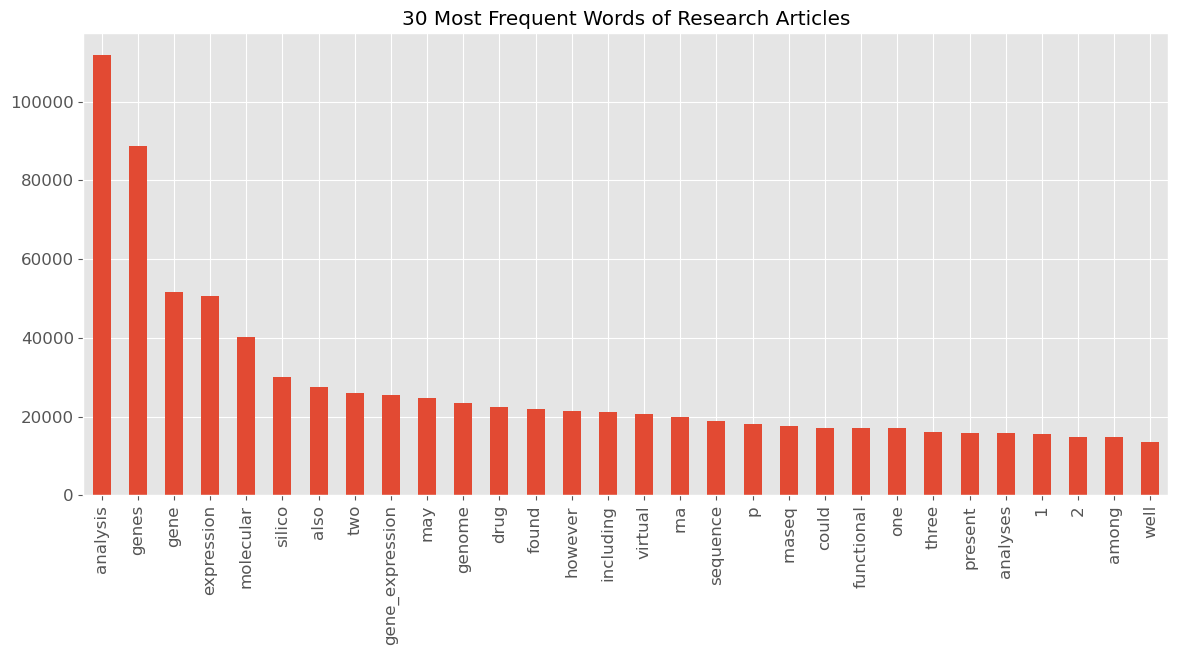

In [11]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))  
freq = pd.Series(" ".join(data['text']).split()).value_counts()[:30]  # Extract top 30 most frequent words

# Plotting the top 30 most frequent words
freq.plot(kind="bar", fontsize=12, title="30 Most Frequent Words of Research Articles")

# Saving the plot to an image
plt.savefig('Top30words.png', bbox_inches='tight')
plt.show()

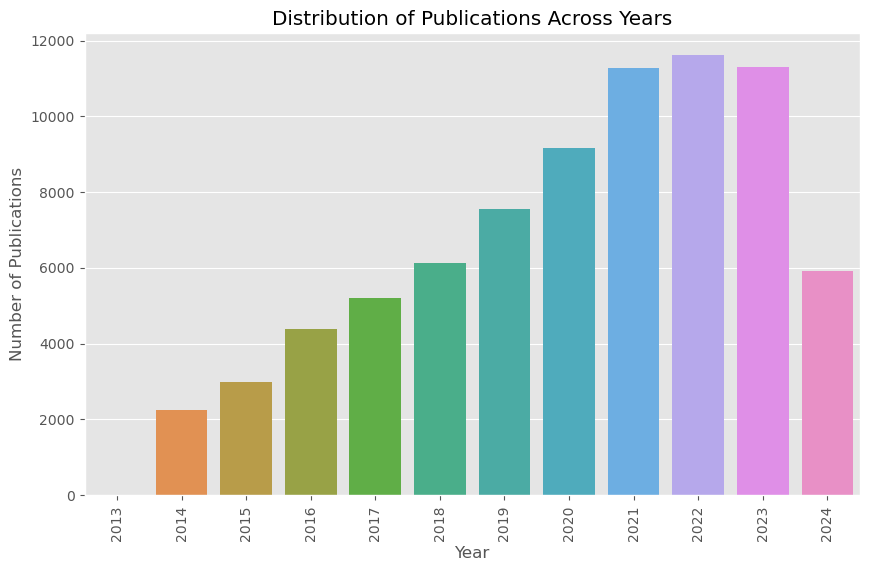

In [12]:
# Distribution of publications across all years
plt.figure(figsize=(10, 6))
sns.countplot(x='DATE OF PUBLICATION', data=data)
plt.title('Distribution of Publications Across Years')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.xticks(rotation=90)
plt.show()

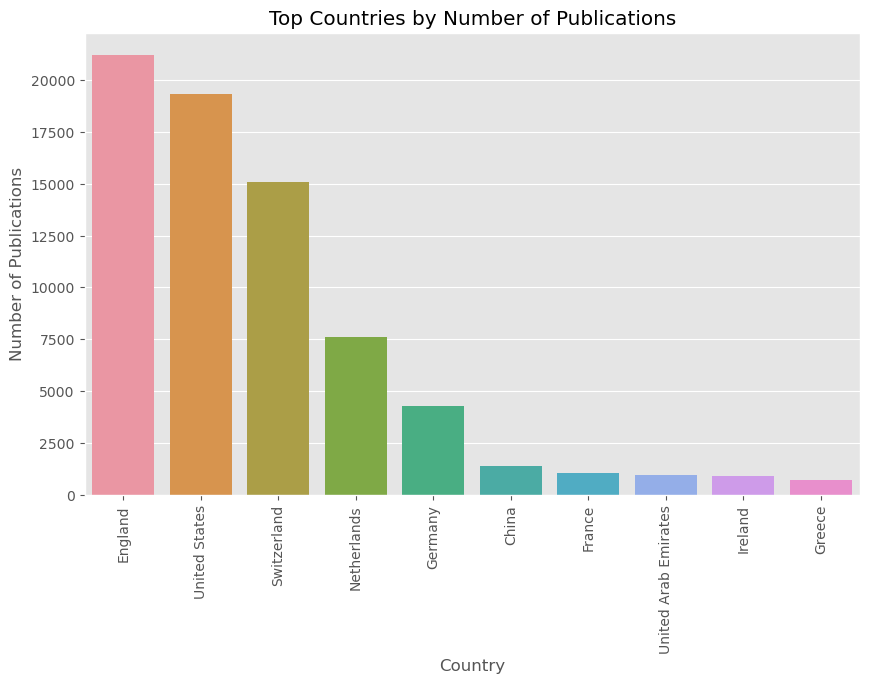

In [13]:
# Analysis: Top countries who published the papers
top_countries = data['PLACE OF PUBLICATION'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_countries.values, x=top_countries.index)
plt.title('Top Countries by Number of Publications')
plt.ylabel('Number of Publications')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.show()

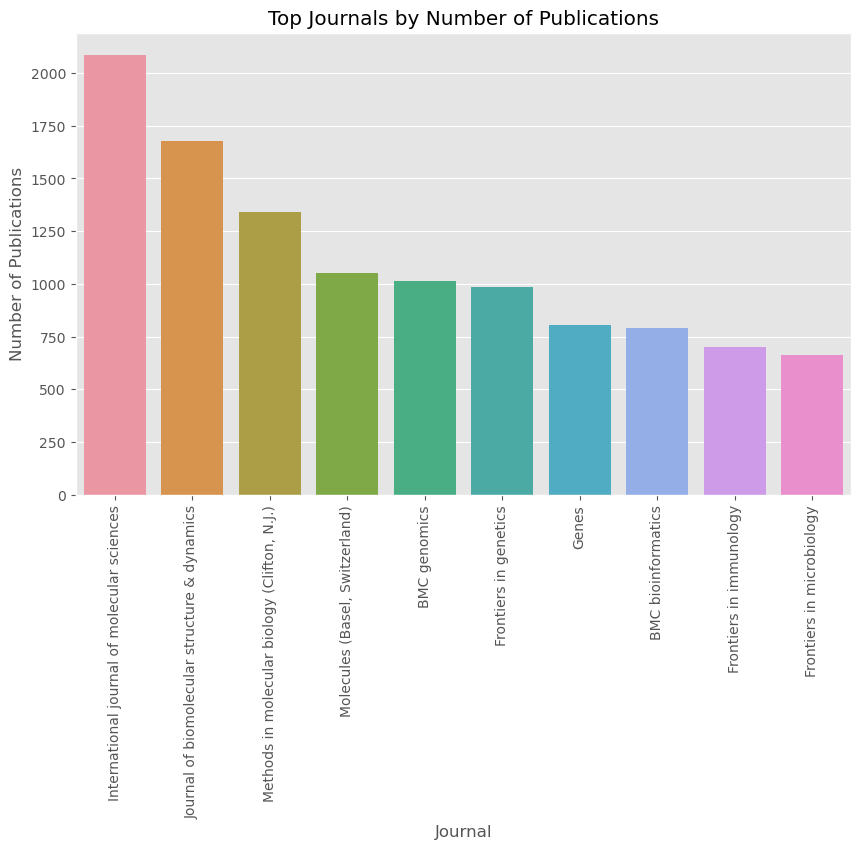

In [14]:
# Analysis: Top journals in which papers were published
top_journals = data['JOURNAL TITLE'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=top_journals.values, x=top_journals.index)
plt.title('Top Journals by Number of Publications')
plt.ylabel('Number of Publications')
plt.xlabel('Journal')
plt.xticks(rotation=90)
plt.show()

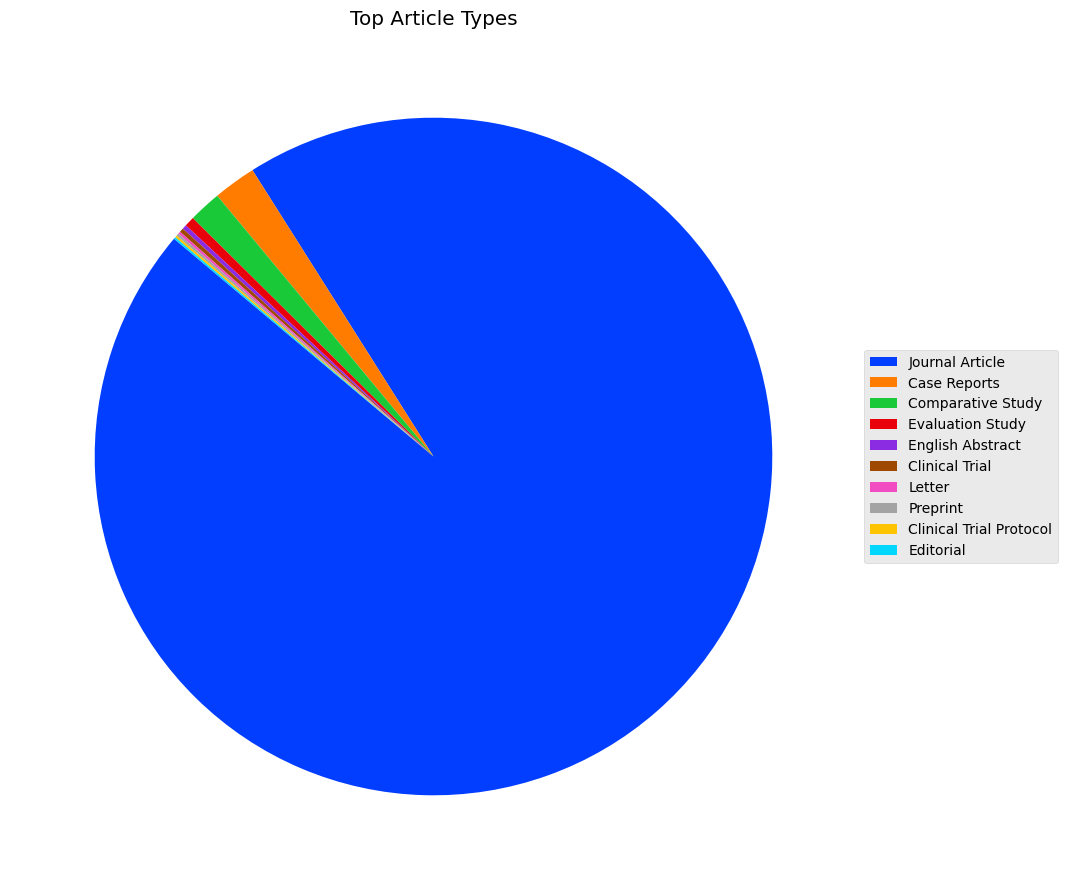

In [15]:
# Top article types
top_article_types = data['PUBLICATION TYPE'].value_counts().head(10)

# Plot the pie chart
plt.figure(figsize=(15,11))
plt.pie(top_article_types, startangle=140, colors=sns.color_palette('bright', len(top_article_types)))
plt.title('Top Article Types')
plt.legend(top_article_types.index, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [16]:
# Topic Modeling Preprocessing
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(data['text'])
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_dtm = tfidf_vectorizer.fit_transform(data['text'])

In [17]:
# LDA Model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(dtm)

# NMF Model
nmf = NMF(n_components=10, random_state=42)
nmf.fit(tfidf_dtm)

NMF(n_components=10, random_state=42)

In [18]:
import pyLDAvis
import pyLDAvis.lda_model

lda_vis_data = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer)

# Display the visualization in the notebook
pyLDAvis.display(lda_vis_data)

# Optionally, save the visualization as an HTML file
pyLDAvis.save_html(lda_vis_data, 'LDA_Visualization.html')

In [19]:
# Define a function to display topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [20]:
# Display LDA topics
display_topics(lda, vectorizer.get_feature_names_out(), 10)

Topic 0:
virtual screening ngs medicine practice nextgeneration primary analysis including test
Topic 1:
genes analysis expression gene gene_expression molecular analyses including normal analyzed
Topic 2:
mirnas expression mirna analysis genes micrornas gene_expression muscle microrna injury
Topic 3:
drug molecular silico virtual_screening molecular_docking drugs docking analysis screening drug_discovery
Topic 4:
analysis functional gene diseases silico function heart cardiac neural disorders
Topic 5:
expression genes analysis gene rnaseq rna gene_expression lncrnas differentiation mrna
Topic 6:
virtual gene analysis type coronary values case congenital nov autosomal
Topic 7:
genes analysis gene expression rnaseq gene_expression rice factors conserved tolerance
Topic 8:
analysis genome sequence sequences gene genes rna nextgeneration genomes ngs
Topic 9:
analysis silico molecular structural membrane effect mass vivo antiinflammatory antioxidant


In [21]:
# Display NMF topics
display_topics(nmf, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 0:
genes analysis gene_expression gene kyoto microarray encyclopedia coexpression cytoscape analyses
Topic 1:
virtual_screening molecular molecular_docking docking silico ligand site structurebased kcalmol hits
Topic 2:
genome sequence ngs sequences nextgeneration genomes analysis genomics generation reference
Topic 3:
mirnas mirna micrornas microrna expression mrnas rnas mrna circrnas mirnamrna
Topic 4:
virtual screening test interventions anxiety practice physical stroke objective healthcare
Topic 5:
rna rnaseq circrnas rnas scrnaseq circular gene_expression analysis circrna protocol
Topic 6:
drug drugs drug_discovery silico discovery screening diseases coronavirus recent effective
Topic 7:
expression analysis adenocarcinoma biomarker microenvironment gene_expression gc immunotherapy os poor
Topic 8:
lncrnas lncrna rnas mrnas cerna rna coexpression expression roles networks
Topic 9:
gene analysis silico expression functional drought function rice promoter type


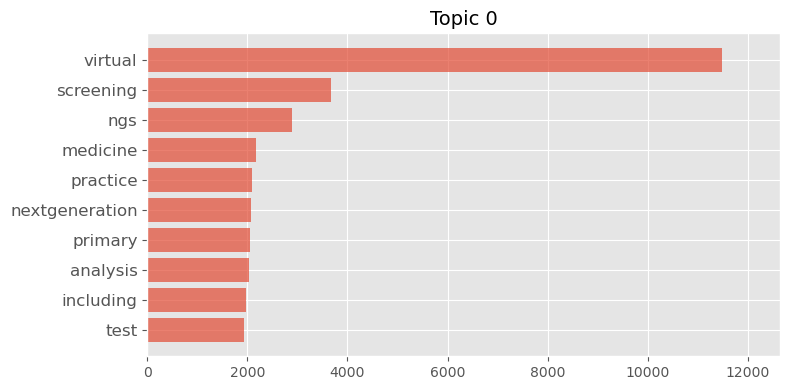

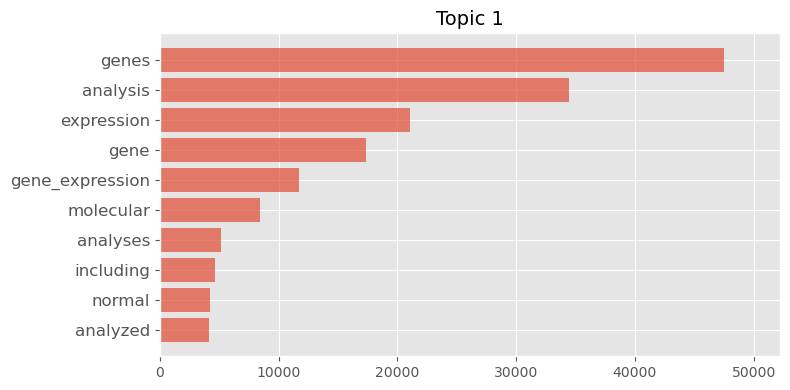

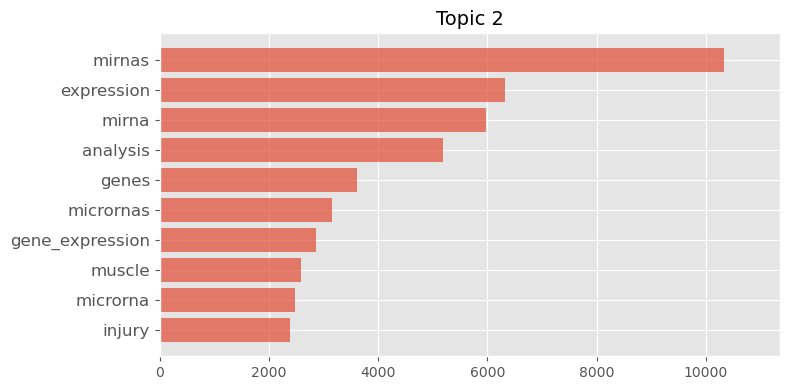

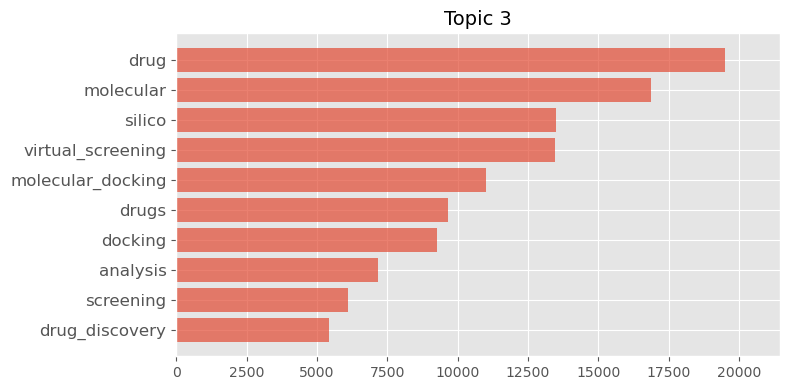

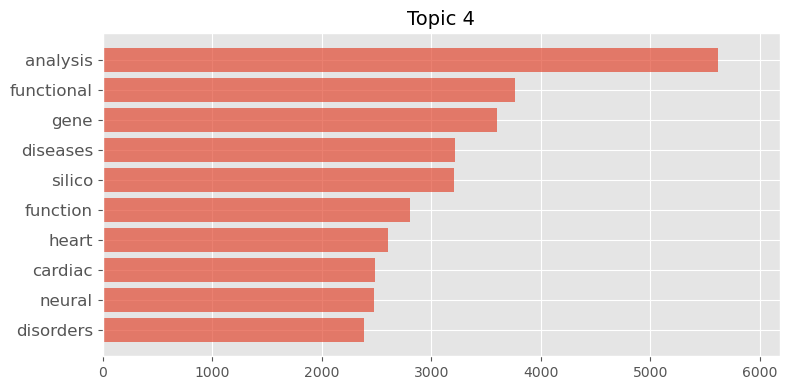

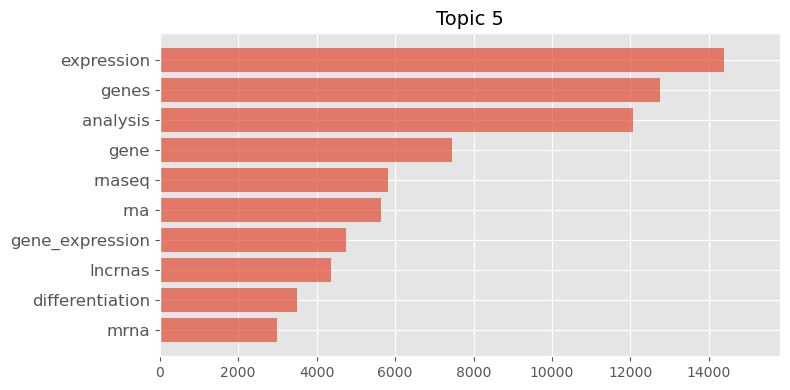

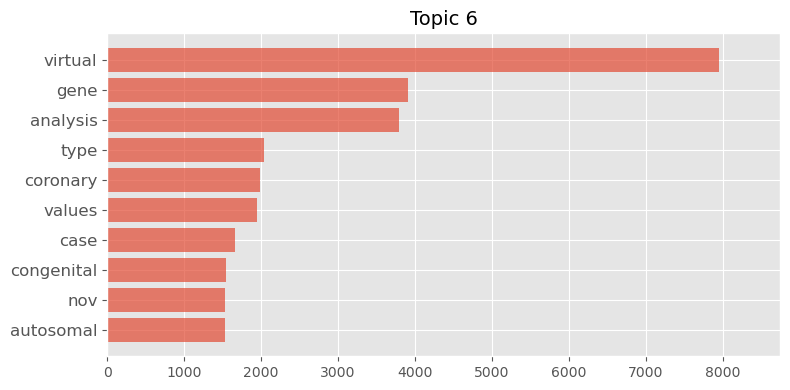

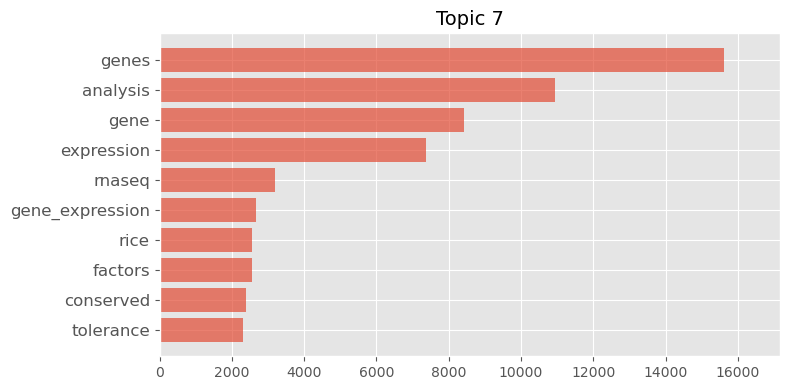

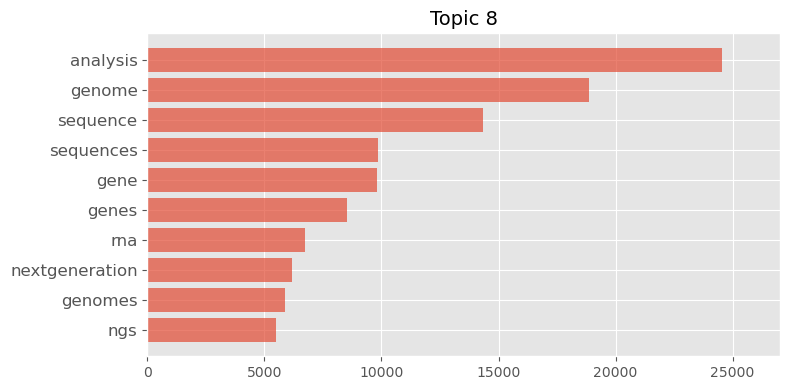

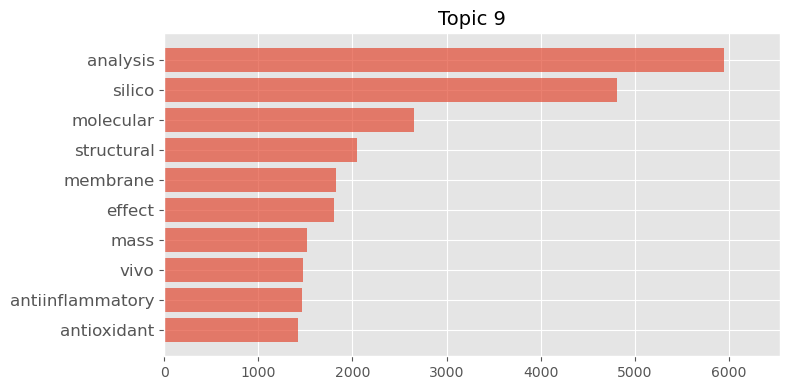

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Get NMF topic-word distributions
num_topics = 10  # As you have defined in NMF
num_words = 10  # Number of top words to display per topic

# Extract topic-word distributions and feature names
nmf_topic_word_distributions = lda.components_  # Shape: (num_topics, num_words_in_vocabulary)
nmf_feature_names = tfidf_vectorizer.get_feature_names_out()  # Using the TF-IDF vectorizer for NMF

# Show each topic as a separate image
for i, topic_dist in enumerate(nmf_topic_word_distributions):
    # Create a new figure for each topic
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Get the top word indices for the current topic
    top_word_indices = topic_dist.argsort()[-num_words:][::-1]  # Get indices of top words
    top_words = [nmf_feature_names[idx] for idx in top_word_indices]  # Get corresponding words
    top_word_probs = topic_dist[top_word_indices]  # Get their probabilities (or weights)
    
    # Plot the words and their probabilities
    ax.barh(np.arange(len(top_words)), top_word_probs, alpha=0.7)
    ax.set_yticks(np.arange(len(top_words)))
    ax.set_yticklabels(top_words, fontsize=12)
    ax.invert_yaxis()  # Invert y-axis to display the most probable word on top
    ax.set_title(f'Topic {i}', fontsize=14)  # Topic names now start from 0
    ax.set_xlim(0, max(top_word_probs) * 1.1)  # Set x-axis limit slightly above the max probability
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


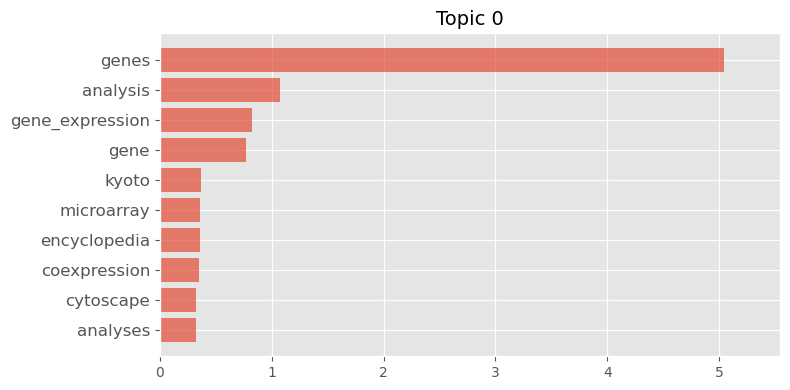

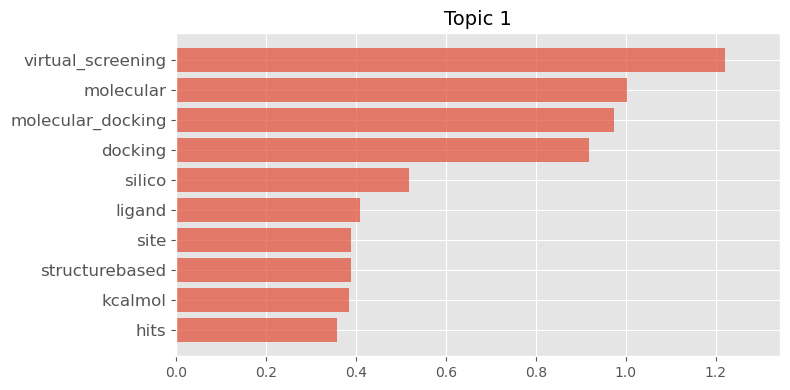

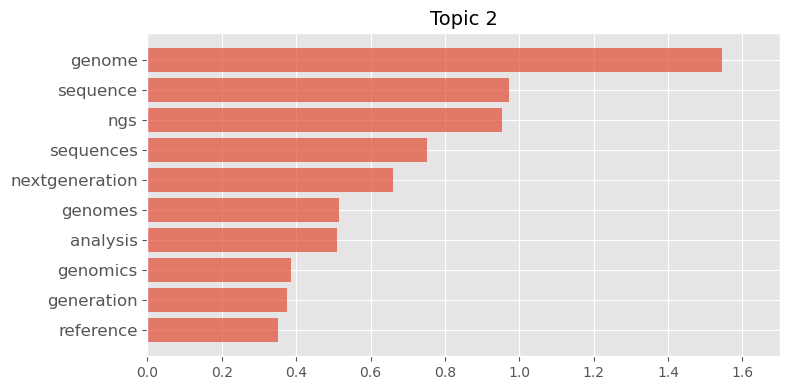

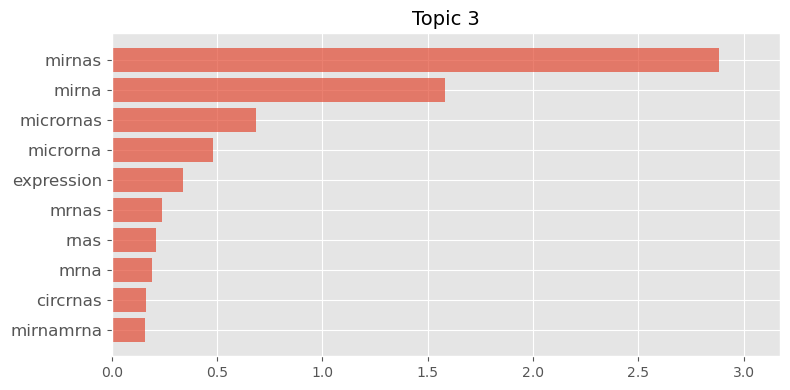

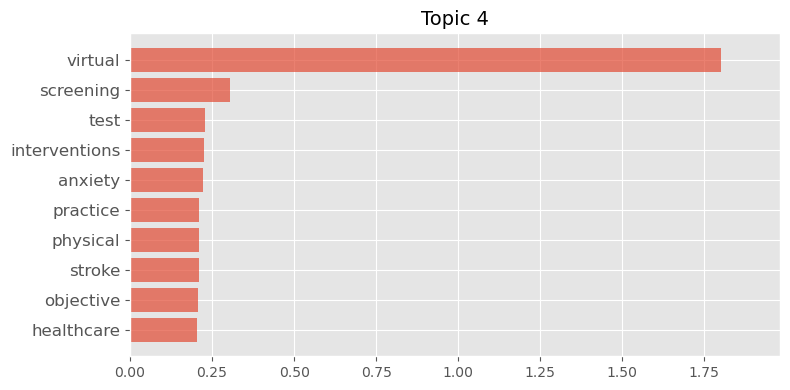

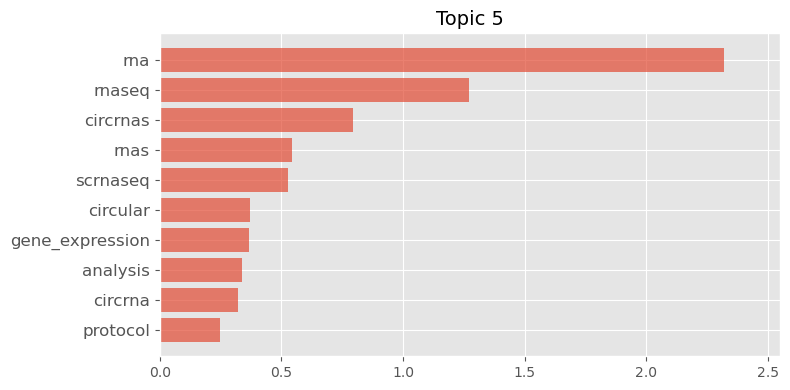

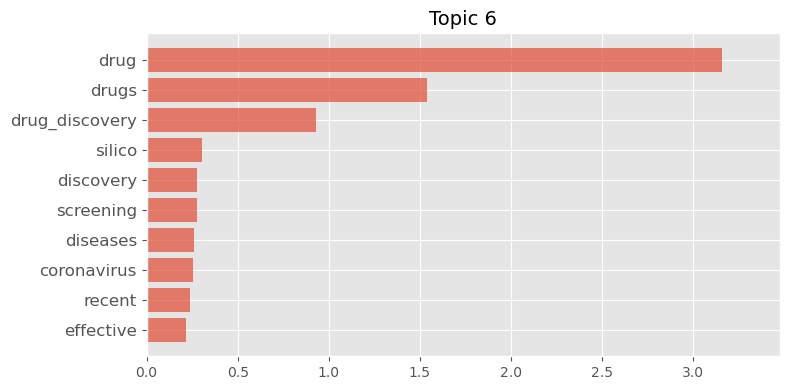

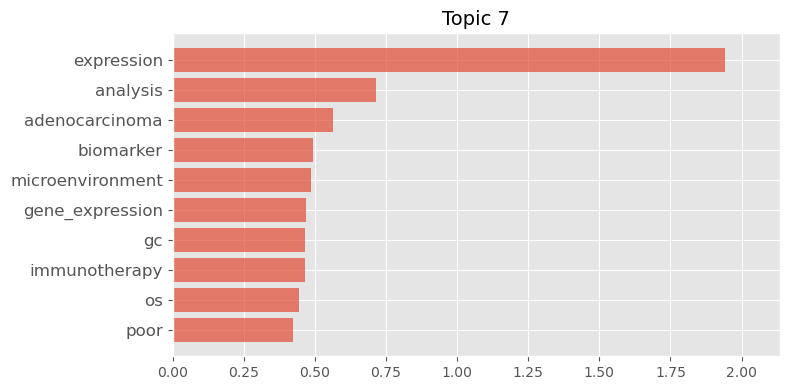

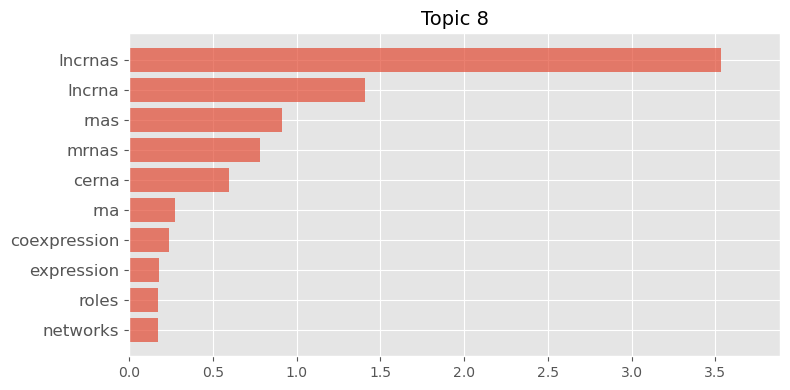

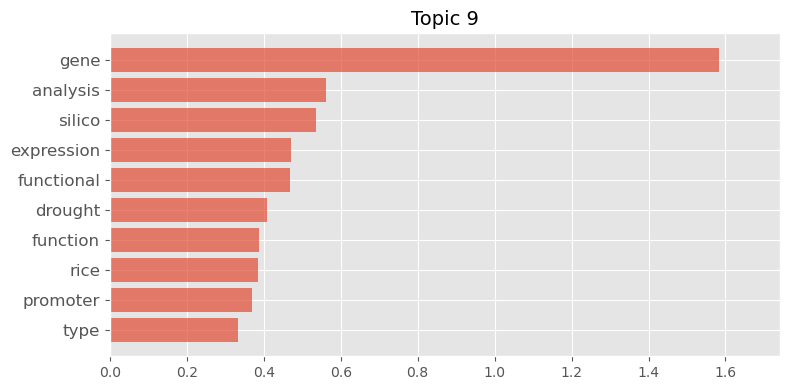

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Get NMF topic-word distributions
num_topics = 10  # As you have defined in NMF
num_words = 10  # Number of top words to display per topic

# Extract topic-word distributions and feature names
nmf_topic_word_distributions = nmf.components_  # Shape: (num_topics, num_words_in_vocabulary)
nmf_feature_names = tfidf_vectorizer.get_feature_names_out()  # Using the TF-IDF vectorizer for NMF

# Show each topic as a separate image
for i, topic_dist in enumerate(nmf_topic_word_distributions):
    # Create a new figure for each topic
    fig, ax = plt.subplots(figsize=(8, 4))
    
    # Get the top word indices for the current topic
    top_word_indices = topic_dist.argsort()[-num_words:][::-1]  # Get indices of top words
    top_words = [nmf_feature_names[idx] for idx in top_word_indices]  # Get corresponding words
    top_word_probs = topic_dist[top_word_indices]  # Get their probabilities (or weights)
    
    # Plot the words and their probabilities
    ax.barh(np.arange(len(top_words)), top_word_probs, alpha=0.7)
    ax.set_yticks(np.arange(len(top_words)))
    ax.set_yticklabels(top_words, fontsize=12)
    ax.invert_yaxis()  # Invert y-axis to display the most probable word on top
    ax.set_title(f'Topic {i}', fontsize=14)  # Topic names now start from 0
    ax.set_xlim(0, max(top_word_probs) * 1.1)  # Set x-axis limit slightly above the max probability
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()


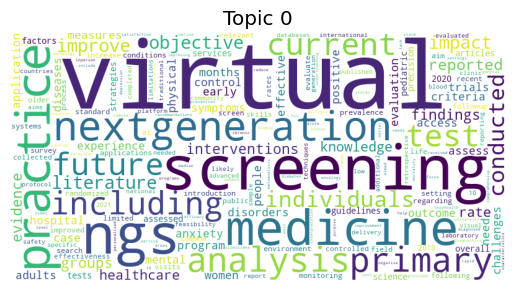

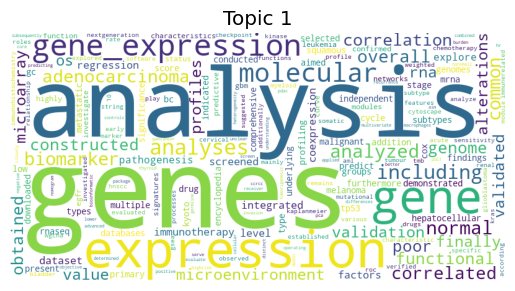

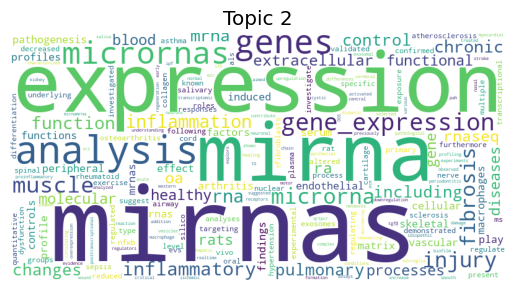

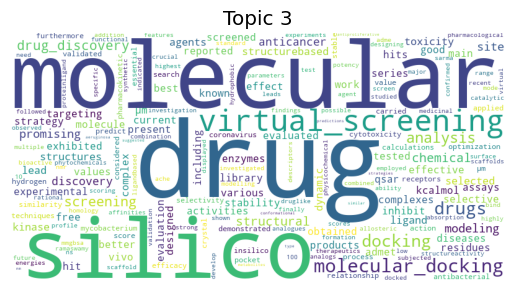

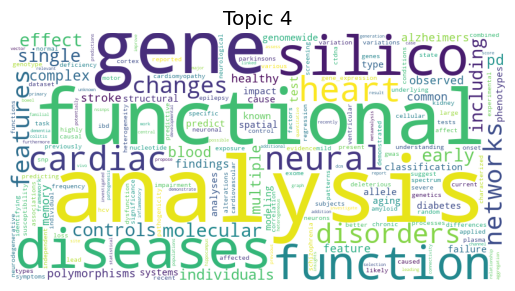

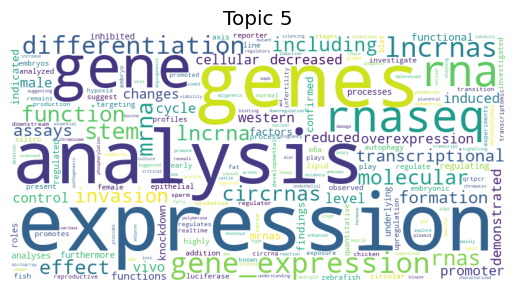

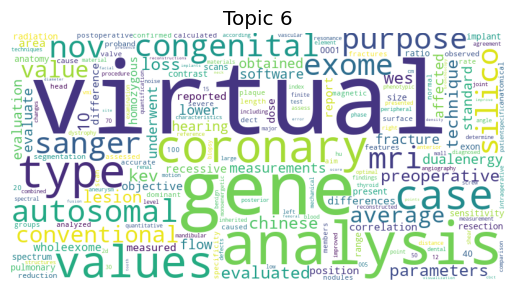

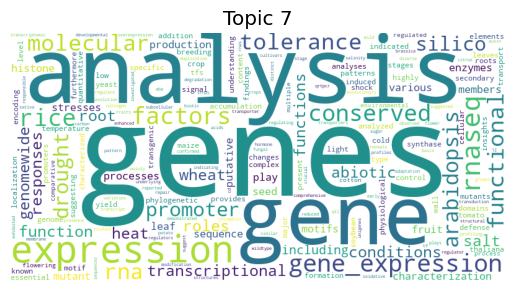

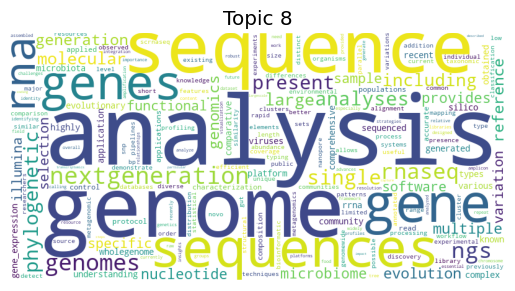

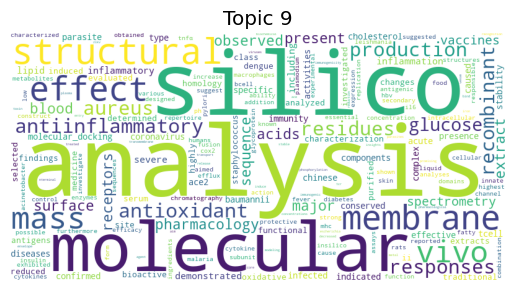

In [32]:
# Visualize LDA topics with WordCloud
for idx, topic in enumerate(lda.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white').fit_words(dict(zip(vectorizer.get_feature_names_out(), topic)))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Topic {idx}')
    plt.show()

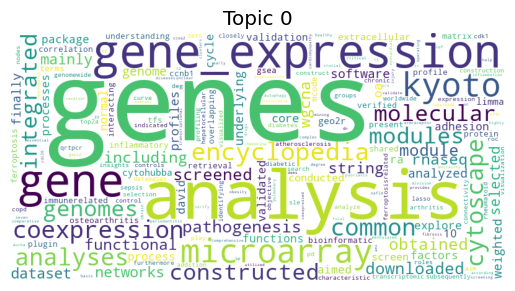

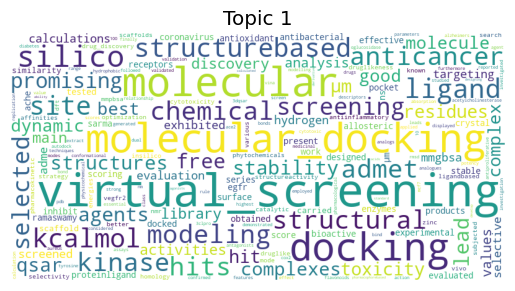

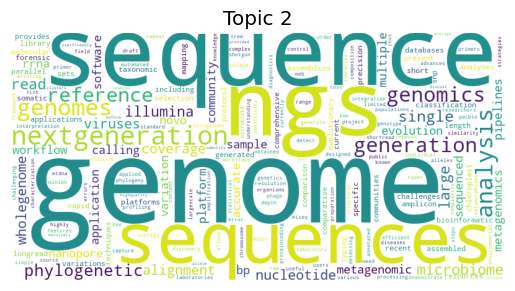

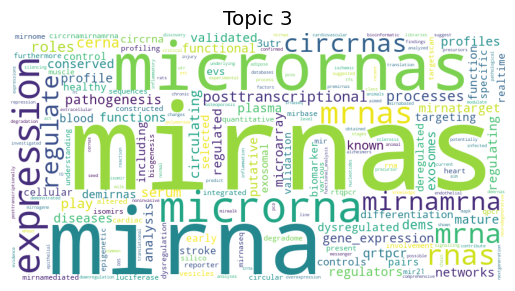

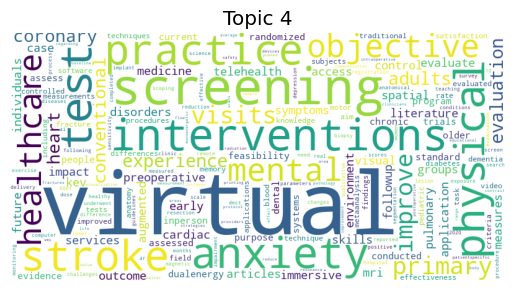

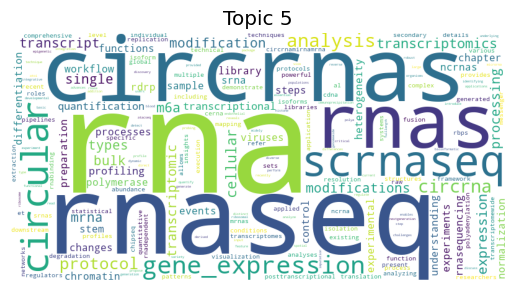

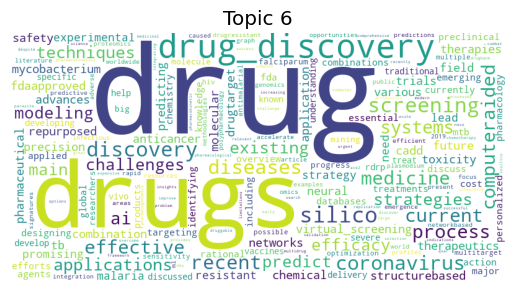

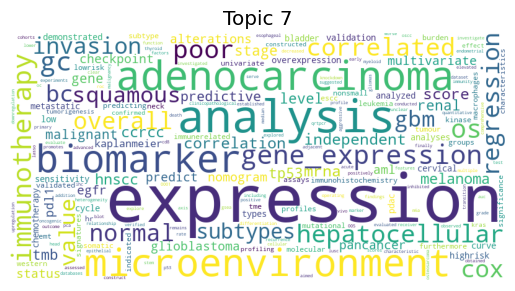

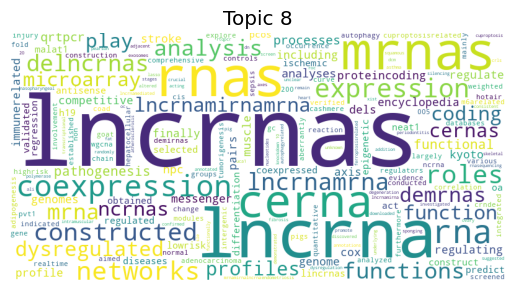

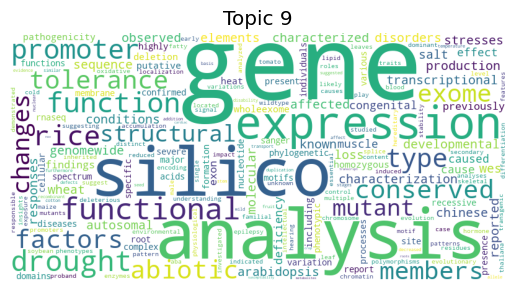

In [33]:
# Visualize NMF topics with WordCloud
for idx, topic in enumerate(nmf.components_):
    plt.figure()
    wordcloud = WordCloud(width=800, height=400, background_color='white').fit_words(dict(zip(tfidf_vectorizer.get_feature_names_out(), topic)))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Topic {idx}')
    plt.show()

In [34]:
# Calculate Coherence Score for LDA
texts = [text.split() for text in data['text']]
id2word = corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=42)
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print(f'Coherence Score for LDA: {coherence_lda}')

Coherence Score for LDA: 0.47347558747720314


In [35]:
# Calculate Coherence Score for NMF
nmf_model_gensim = gensim.models.nmf.Nmf(corpus=corpus, num_topics=10, id2word=id2word, random_state=42)
coherence_model_nmf = CoherenceModel(model=nmf_model_gensim, texts=texts, dictionary=id2word, coherence='c_v')
coherence_nmf = coherence_model_nmf.get_coherence()
print(f'Coherence Score for NMF: {coherence_nmf}')

E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:578: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:607: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:6

E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:620: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  if isinstance(corpus, scipy.sparse.csc.csc_matrix):
E:\Anaconda\Lib\site-packages\gensim\models\nmf.py:6

Coherence Score for NMF: 0.4838742764620447
